In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

#MODELOS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN as RNN

#metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
# Evitar overffiting
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout



## LInks interessantes:[
  https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
tf.random.set_seed(7)

### Importando os dados já processados

In [134]:
train_test = np.load("/content/drive/Shareddrives/TCC_PES/codigos/data_f24.npy",allow_pickle=True)

In [130]:
def metrics_(testY,testPredict):
  # testPredict = model.predict(testX)
  y_true = testY[:,0]*100
  y_pred = testPredict*100

  mse  = mean_squared_error(y_true, y_pred) 
  rmse = mean_squared_error(y_true, y_pred, squared = False)
  max_e =  max_error(y_true, y_pred) 
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  return([mse, rmse, max_e, mae,r2])

In [81]:
def data_func (train_test, aenv):
  
  trainX = train_test[train_test[:,30]!=aenv][:,:20]/100
  trainY = train_test[train_test[:,30]!=aenv][:,29]/100
  trainX = np.reshape(trainX, (trainX.shape[0],1, trainX[0].shape[0]))
  trainY = np.reshape(trainY, (trainY.shape[0],1, 1))

  testX = train_test[train_test[:,30]==aenv][:,:20]/100
  testY = train_test[train_test[:,30]==aenv][:,29]/100
  testX  = np.reshape(testX , (testX.shape[0], 1, testX[0].shape[0]))
  testY = np.reshape(testY, (testY.shape[0], 1,1))

  return trainX, trainY, testX, testY


def plot_results():
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)

  print("Aeronave: "+ str(int(aenv))+ "   " +name)

  plt.figure(dpi=100,figsize=(20,5))
  plt.plot(testY[:,0]*100,':ok')
  plt.plot(testPredict[:,0]*100,'-xm')
  plt.title("Aeronave: "+ str(int(aenv)))
  plt.xlabel("Dias uteis desde o dia 30")
  plt.ylabel("Desgaste")
  plt.legend(["Esperado",'Predito'])
  

In [85]:
def recorrent_model (name,units=5,look_back=20):
  model = Sequential()
  if name == "LSTM":
      model.add(LSTM(units, input_shape=(1, look_back)))
  elif name=="GRU":
      model.add(GRU(units, input_shape=(1, look_back)))
  elif name == "RNN":
      model.add(RNN(units, input_shape=(1, look_back)))
  else:
      print("Model not found")

  # model.add(Dropout(0.2))
  model.add(Dense(1))

  return model

In [135]:
# create and fit the LSTM network] [mse, rmse, max_e, mae,r2]
data_results = pd.DataFrame([],columns=['MSE','RMSE', 'MaxE', 'MAE', "R2",'Fold','Modelo','Parâmetros'])


for name in ["RNN","GRU","LSTM"]:
  results = []
  for k in range(0,8):
    look_back = 20
    aenv=np.unique(train_test[:,30])[k]

    trainX, trainY, testX, testY = data_func (train_test, aenv)

    model = recorrent_model(name=name,units=10,look_back=20)
    early_stopping = EarlyStopping(patience=5)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    
    result = metrics_(testY,model.predict(testX))
    result.append(int(aenv))
    result.append(name)
    result.append(model.count_params())
    
    results.append(result)
    print(result)

  print()
  data_results = pd.concat([data_results, pd.DataFrame(results,columns=['MSE', 'RMSE',  'MaxE', 'MAE', "R2",'Fold','Modelo','Parâmetros'])])

data_results.to_csv('/content/drive/Shareddrives/TCC_PES/codigos/resultados/resul_rnns_f24.csv')

[0.8874133495529256, 0.942026193666039, 2.4873990221290683, 0.8230343079969622, 0.9540739332241549, 1011, 'RNN', 321]
[0.7542593781484433, 0.8684810752966603, 3.3977523016592386, 0.6263963725674436, 0.9802607959308647, 9486, 'RNN', 321]
[1.0780976500508503, 1.0383148125933919, 2.5550932364577648, 0.8714111509709714, 0.905178229858554, 9526, 'RNN', 321]
[1.4195555652647442, 1.1914510335153283, 3.695726112098086, 0.9889430151616827, 0.9107173695803982, 9636, 'RNN', 321]
[1.3769310703912092, 1.1734270622374487, 3.2767179209991752, 0.96870937766402, 0.971833103445934, 9664, 'RNN', 321]
[1.0757576193966294, 1.037187359832653, 4.467174586503319, 0.7832477615122072, 0.9281899810043002, 9678, 'RNN', 321]
[0.5126597688042862, 0.7160026318417316, 2.170225590564854, 0.5513443534158342, 0.9799431627181721, 9770, 'RNN', 321]
[0.7106949475986665, 0.8430272519905074, 5.537630197924258, 0.651717286621242, 0.9608932037064496, 9793, 'RNN', 321]

[0.9946922711106603, 0.9973426046803878, 3.678745054219455

### Visualizando os resultados 

In [113]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns

colors1 = [    
          (15/255,114/255,255/255,1), # blue 
          (224/255,0/255,193/255,.88), #pink
          (1.0, 0.807843137254902, 0.0392156862745098, 1), #orange
          (0.95, 0, 0, 1), #red
          (0, 0.6666666666666666, 0.6274509803921569, 1), #green
          
          (0, 0.9764705882352941, 0, 0.5), #       
          (10/255,10/255, 130/255, 1), #(0.4, 0.0, 0.6, 1), # green
          (0.6, 0/255, 0.4, 0.8)#
        ]

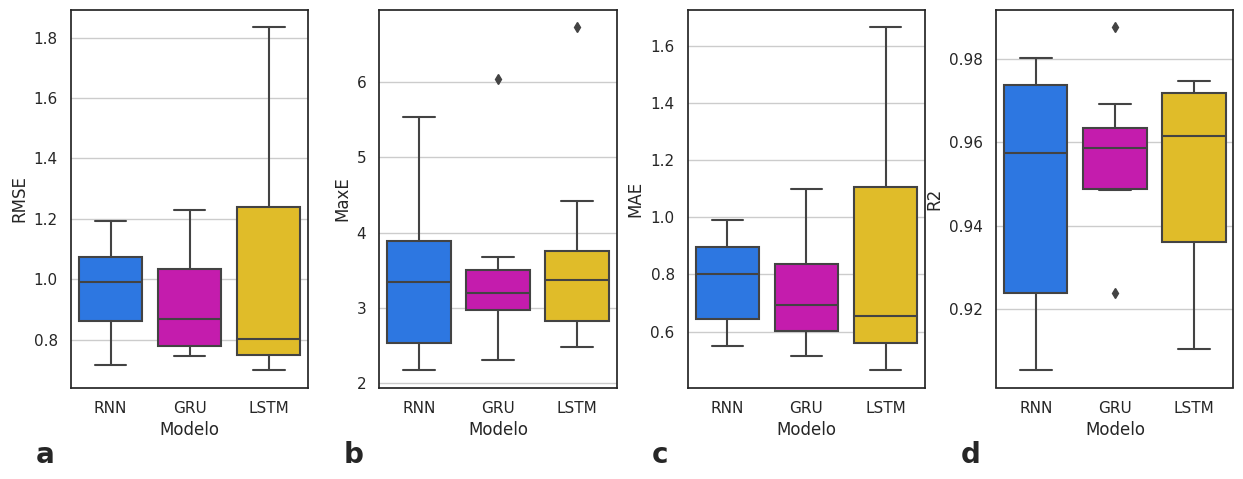

In [137]:
results = data_results


fig = plt.figure(figsize = (15,5),dpi=100)
axes = gridspec.GridSpec(nrows=1, ncols=4, figure=fig, wspace=0.3, hspace=0)
sns.set_theme(style="white", palette=None)
metrics =results.columns[1:-3]
r = [0,0,0,0]
c = [0,1,2,3]
count=0

im = ['a','b','c','d']
for metric in metrics:
    ax = fig.add_subplot(axes[r[count],c[count]])
    ax.grid()
    sns.boxplot(y=results[metric],x=results['Modelo'],ax=ax,palette=colors1)
    ax.text(-0.15, -0.2, im[count], size=20, weight='bold', transform=ax.transAxes)
    count+=1
plt.savefig('/content/drive/Shareddrives/TCC_PES/codigos/resultados/fig_metrics_f24.pdf', format="pdf", dpi=1000, bbox_inches="tight")

### Melhor modelo


Aeronave: 1011
Train Score: 0.007 RMSE
Test Score: 0.006 RMSE


Aeronave: 9486
Train Score: 0.012 RMSE
Test Score: 0.017 RMSE


Aeronave: 9526
Train Score: 0.012 RMSE
Test Score: 0.011 RMSE


Aeronave: 9636
Train Score: 0.008 RMSE
Test Score: 0.008 RMSE


Aeronave: 9664
Train Score: 0.008 RMSE
Test Score: 0.007 RMSE


Aeronave: 9678
Train Score: 0.008 RMSE
Test Score: 0.009 RMSE


Aeronave: 9770
Train Score: 0.008 RMSE
Test Score: 0.008 RMSE


Aeronave: 9793
Train Score: 0.007 RMSE
Test Score: 0.007 RMSE



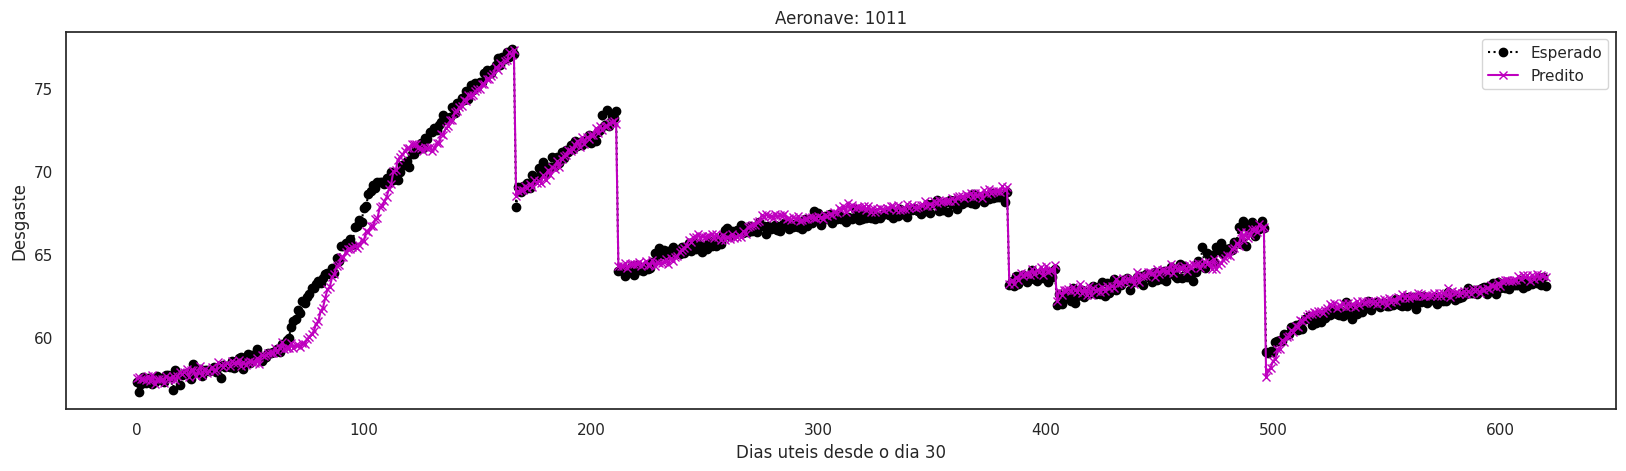

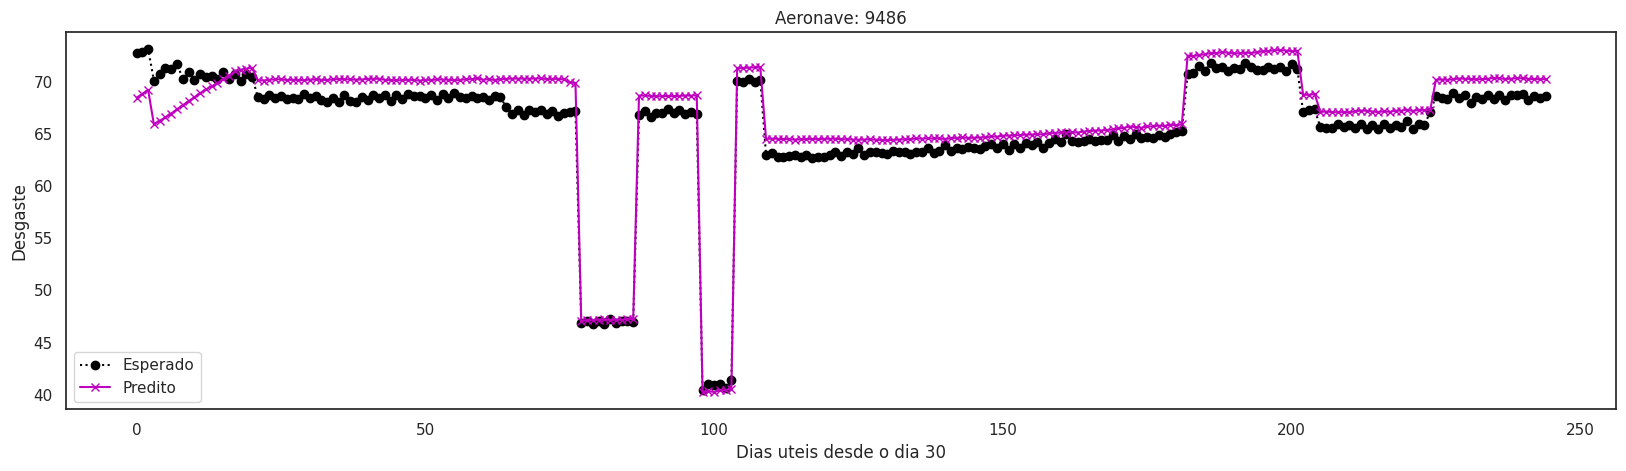

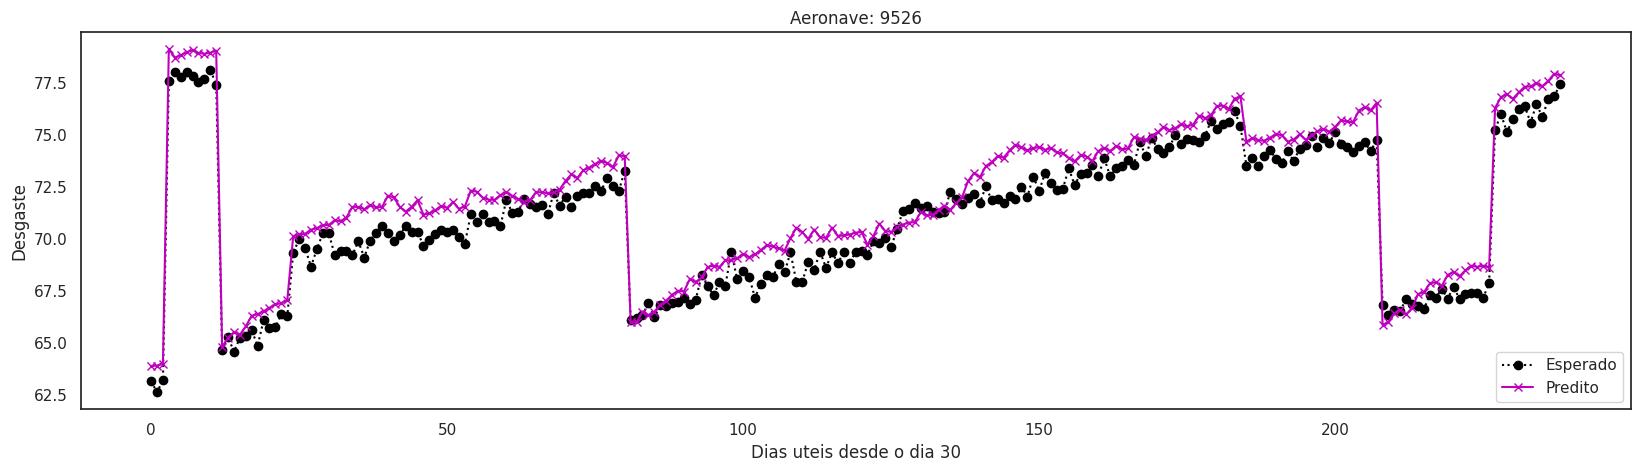

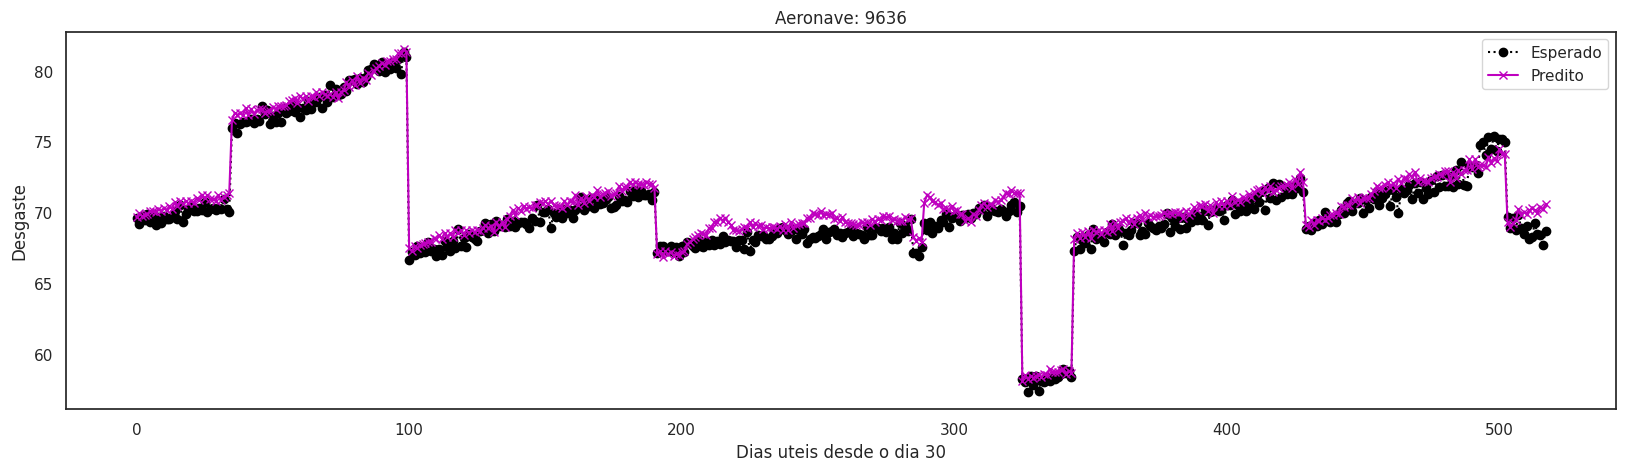

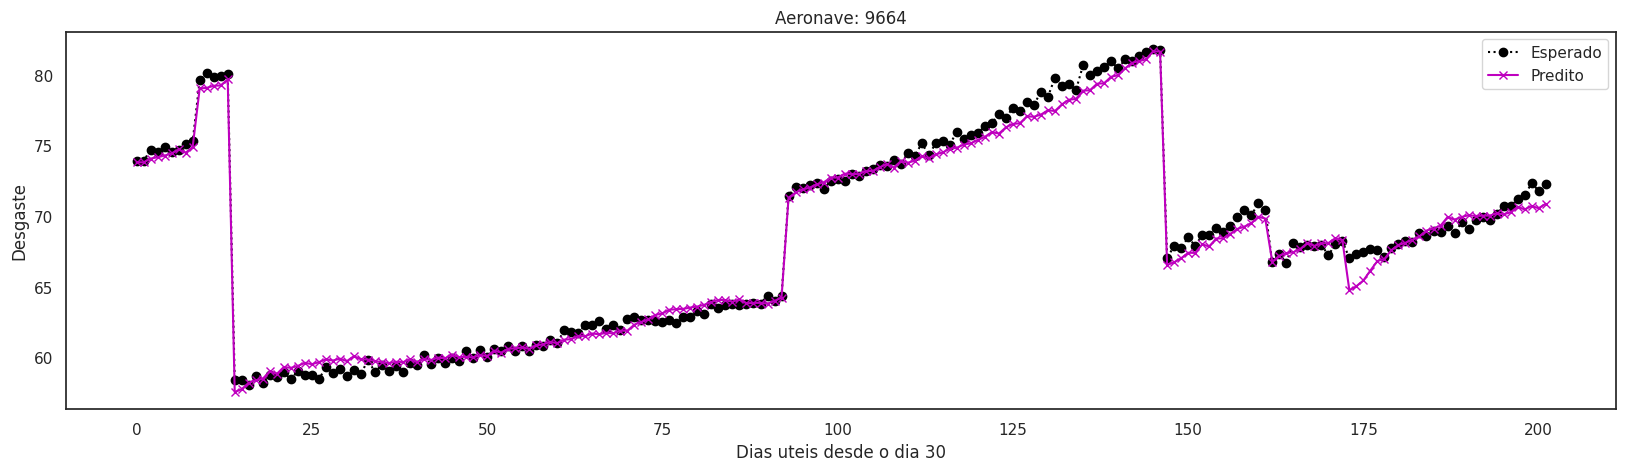

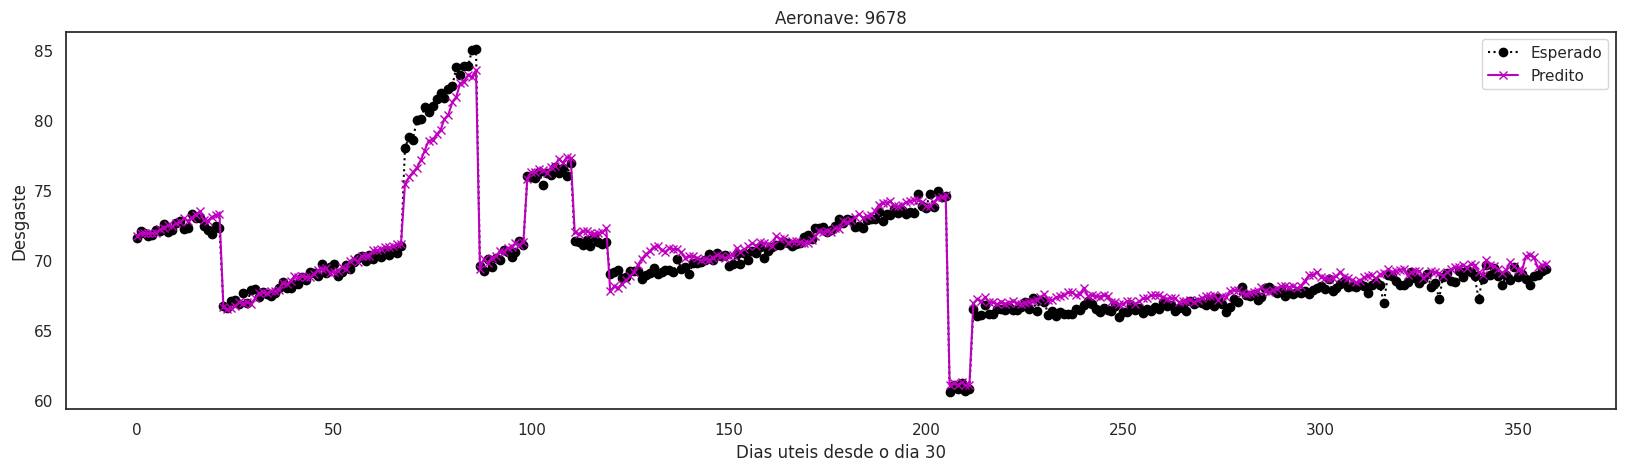

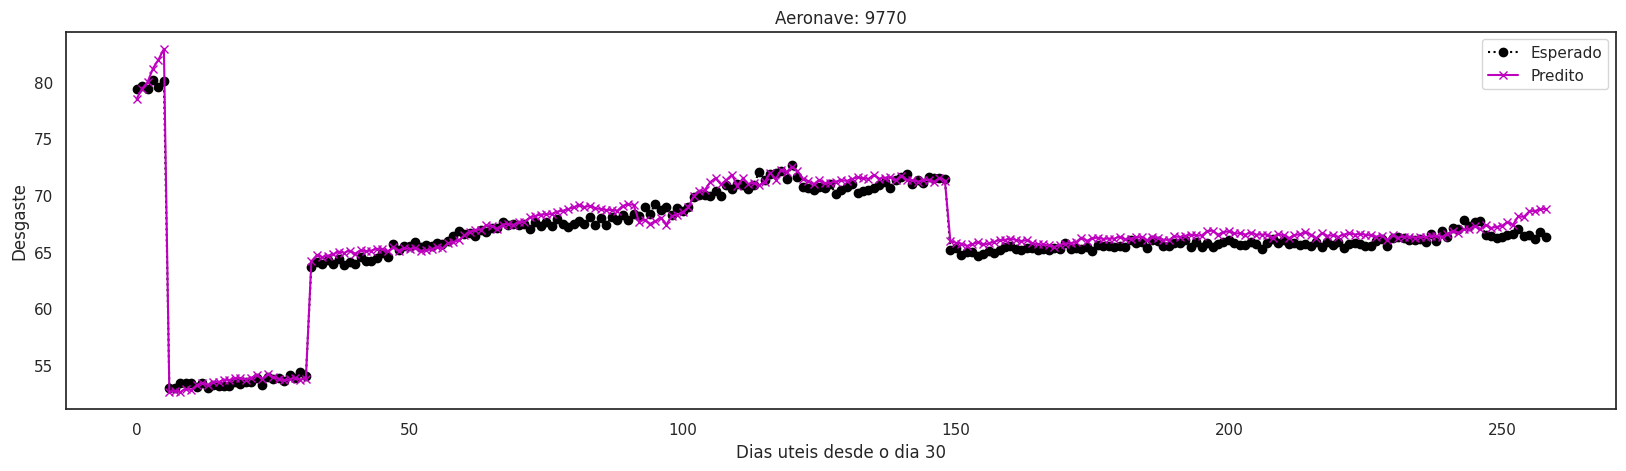

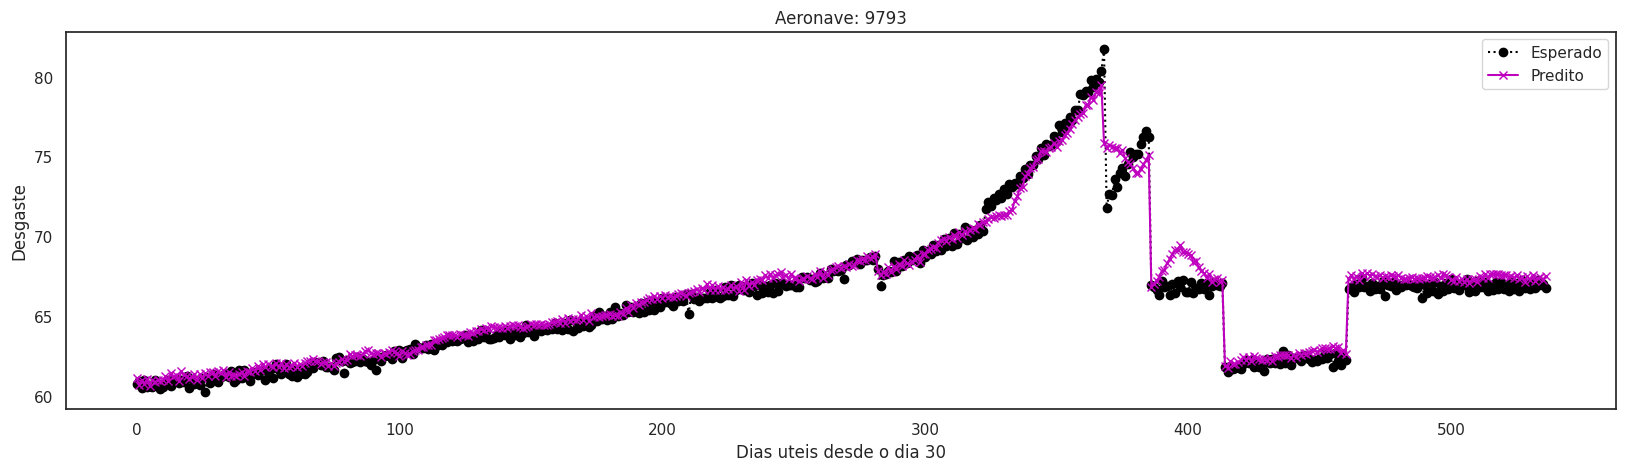

In [138]:
name ="LSTM"

for k in range(0,8):
  look_back = 20
  aenv=np.unique(train_test[:,30])[k]

  trainX, trainY, testX, testY = data_func (train_test, aenv)

  model = recorrent_model(name=name,units=10,look_back=20)
  early_stopping = EarlyStopping(patience=5)
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(trainX, trainY, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping], verbose=0)
  plot_results()
  